In [1]:
import torch
import numpy as np
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob
import os
import pandas as pd
import timm


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

labels_train_val = pd.read_csv('../../../../..//data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('../../../../..//data/test_list.txt')
labels_test.columns = ['Image_Index']

disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('../../../../..//data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('../../../../../data/images_all/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
unique_patients = np.unique(labels_df['Patient_ID'])

train_val_df = labels_df[labels_df['Image_Index'].isin(labels_train_val['Image_Index'])]
test_df = labels_df[labels_df['Image_Index'].isin(labels_test['Image_Index'])]
test_df.reset_index(drop=True, inplace=True)

print('train_val size', train_val_df.shape[0])
print('test size', test_df.shape[0])

item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]

def splitter(df):
    return L(range(len(df))), L([])  # 두 번째 리스트는 비워 두어 검증 세트가 없음을 의미

def get_x(row):
    return row['Paths']

def get_y(row):
    # labels = row[disease_labels].tolist()
    labels = row[disease_labels].values.astype(int)

    # if not isinstance(np.int64(labels[0]), np.int64):
        # print('labels : ', labels, type(labels[0]))
    return labels

arch = 'coatnet_2_rw_224.sw_in12k_ft_in1k'

# Test set evaluation
test_dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=disease_labels)),
    get_x=get_x,
    get_y=get_y,
    item_tfms=item_transforms,
    batch_tfms=batch_transforms,
    splitter=splitter
)

test_dls = test_dblock.dataloaders(test_df, bs=32, shuffle=False, drop_last=False)

learn = vision_learner(test_dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()])
learn.model = torch.nn.DataParallel(learn.model)

learn.load('coatnet-70-10-20-split')

# Get predictions and targets
preds, targets = learn.get_preds(dl=test_dls[0])

# Convert predictions to binary (thresholding)
preds_binary = (preds > 0.5).int()

# Initialize metrics
accuracy_per_disease = []
f1_per_disease = []
roc_auc_per_disease = []

# Calculate metrics for each disease
for i, disease in enumerate(disease_labels):
    accuracy = accuracy_multi(preds[:, i], targets[:, i])
    f1 = F1ScoreMulti(average='macro')(preds_binary[:, i], targets[:, i])
    roc_auc = RocAucMulti()(preds[:, i], targets[:, i])
    
    accuracy_per_disease.append(accuracy)
    f1_per_disease.append(f1)
    roc_auc_per_disease.append(roc_auc)
    
    print(f'{disease}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1 Score: {f1:.4f}')
    print(f'  ROC AUC: {roc_auc:.4f}')
    print()

# Optionally, convert results to DataFrame for better visualization
results_df = pd.DataFrame({
    'Disease': disease_labels,
    'Accuracy': accuracy_per_disease,
    'F1 Score': f1_per_disease,
    'ROC AUC': roc_auc_per_disease
})

print(results_df)

100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


train_val size 86523
test size 25595


## XGB

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
from torchvision import models, transforms
from PIL import Image
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle

import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# 피클 파일에서 데이터 로드
with open('train_val_features.pkl', 'rb') as f:
    train_val_data = pickle.load(f)

with open('test_features.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
# image_path = test_dls.items['Paths']
# test_data2 = {'paths':[], 'features':[]}
# for i, (p,f) in enumerate(zip(test_data['paths'], test_data['features'])):
#     if p in image_path.values:
#         test_data2['paths'].append(p)
#         test_data2['features'].append(f)
        
# test_data = test_data2
# test_df = test_df[test_df['Paths'].isin(test_data2['paths'])]

In [ ]:
# # 특징과 레이블 분리
X_train = np.stack(train_val_data['features'])
y_train = train_val_df[disease_labels].values

X_test = np.stack(test_data['features'])
y_test = test_df[disease_labels].values

num_classes = 15

# XGBoost 모델 설정
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=num_classes,
    use_label_encoder=False,
    tree_method='gpu_hist',  # GPU를 사용하도록 설정
    gpu_id=3  # 특정 GPU를 지정
)

# tqdm 콜백 클래스 정의
class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total, desc):
        self.total = total
        self.pbar = tqdm(total=total, desc=desc)

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        if epoch == self.total - 1:
            self.pbar.close()
        return False

# OneVsRestClassifier로 멀티레이블 분류기 설정
epochs = 20
multilabel_model = OneVsRestClassifier(xgb_model)

columns = [	"Time",
			"Accuracy",
			"F1_macro",
			"Roc_Auc_macro"]

In [ ]:
# 모델 학습을 위한 맞춤 fit 함수 정의
def custom_fit(model, X_train, y_train, epochs):
    print("Model Fit Start")

    for i in range(y_train.shape[1]):
        print(f"Training for label {i}")
        model.estimator.fit(
            X_train, 
            y_train[:, i], 
            eval_set=[(X_train, y_train[:, i]), (X_test, y_test[:, i])],
            verbose=False, 
            callbacks=[TqdmCallback(epochs, desc=f'Training label {i}')]
        )

# 모델 학습
custom_fit(multilabel_model, X_train, y_train, epochs)

Model Fit Start
Training for label 0


Training label 0:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 1


Training label 1:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 2


Training label 2:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 3


Training label 3:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 4


Training label 4:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 5


Training label 5:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 6


Training label 6:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 7


Training label 7:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 8


Training label 8:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 9


Training label 9:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 10


Training label 10:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 11


Training label 11:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 12


Training label 12:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 13


Training label 13:   0%|          | 0/20 [00:00<?, ?it/s]

Training for label 14


Training label 14:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# 예측
y_pred = multilabel_model.estimator.predict(X_test)
y_pred_proba = multilabel_model.estimator.predict_proba(X_test)  # AUC-ROC 계산을 위해 필요

# 정확도 및 F1 스코어 계산
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

# AUC-ROC 스코어 계산
roc_auc_micro = roc_auc_score(y_test, y_pred_proba, average='micro')
roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')

print(f"Test Accuracy: {accuracy}")
# print(f"Test F1 Score (Micro): {f1_micro}")   # 라벨에 상관없이 전체적인 성능 평가 (==accuracy와 동일)
print(f"Test F1 Score (Macro): {f1_macro}")     # 모든 라벨이 유사한 중요도를 가져 단순 라벨들의 f1_score의 산술평균
# print(f"Test ROC AUC Score (Micro): {roc_auc_micro}") 
print(f"Test ROC AUC Score (Macro): {roc_auc_macro}")

# 각 레이블별 평가 결과 출력
for idx in range(y_test.shape[1]):
    accuracy_label = accuracy_score(y_test[:, idx], y_pred[:, idx])
    f1_label = f1_score(y_test[:, idx], y_pred[:, idx])
    roc_auc_label = roc_auc_score(y_test[:, idx], y_pred_proba[:, idx])
    print(f"Class {idx} - Accuracy: {accuracy_label}, F1 Score: {f1_label}, ROC AUC Score: {roc_auc_label}")


Test Accuracy: 0.0223188122680211
Test F1 Score (Macro): 0.020656081631468145
Test ROC AUC Score (Macro): 0.4934301897230403
Class 0 - Accuracy: 0.5170931822621606, F1 Score: 0.19491939423546653, ROC AUC Score: 0.4898340035307327
Class 1 - Accuracy: 0.4719183434264505, F1 Score: 0.11492183023655562, ROC AUC Score: 0.47226239973149176
Class 2 - Accuracy: 0.7625512795467865, F1 Score: 0.0, ROC AUC Score: 0.5011874620530878
Class 3 - Accuracy: 0.8962688025004883, F1 Score: 0.0, ROC AUC Score: 0.49138177184155174
Class 4 - Accuracy: 0.9642508302402814, F1 Score: 0.0, ROC AUC Score: 0.49697521720647236
Class 5 - Accuracy: 0.9571205313537801, F1 Score: 0.0, ROC AUC Score: 0.4920165253253261
Class 6 - Accuracy: 0.9835905450283259, F1 Score: 0.0, ROC AUC Score: 0.5240319253321983
Class 7 - Accuracy: 0.8207169369017386, F1 Score: 0.0, ROC AUC Score: 0.5003529436270078
Class 8 - Accuracy: 0.9778765383864036, F1 Score: 0.0, ROC AUC Score: 0.4995752676916028
Class 9 - Accuracy: 0.9551670248095331,

## 앙상블 결과

In [ ]:
# Define weights
weight_fastai = 0.7  # You can adjust these weights based on model performance
weight_xgboost = 0.3

# Ensure the predictions are in the same format
preds_xgboost = np.array(y_pred_proba)

# Weighted ensemble predictions
ensemble_preds = weight_fastai * preds + weight_xgboost * preds_xgboost


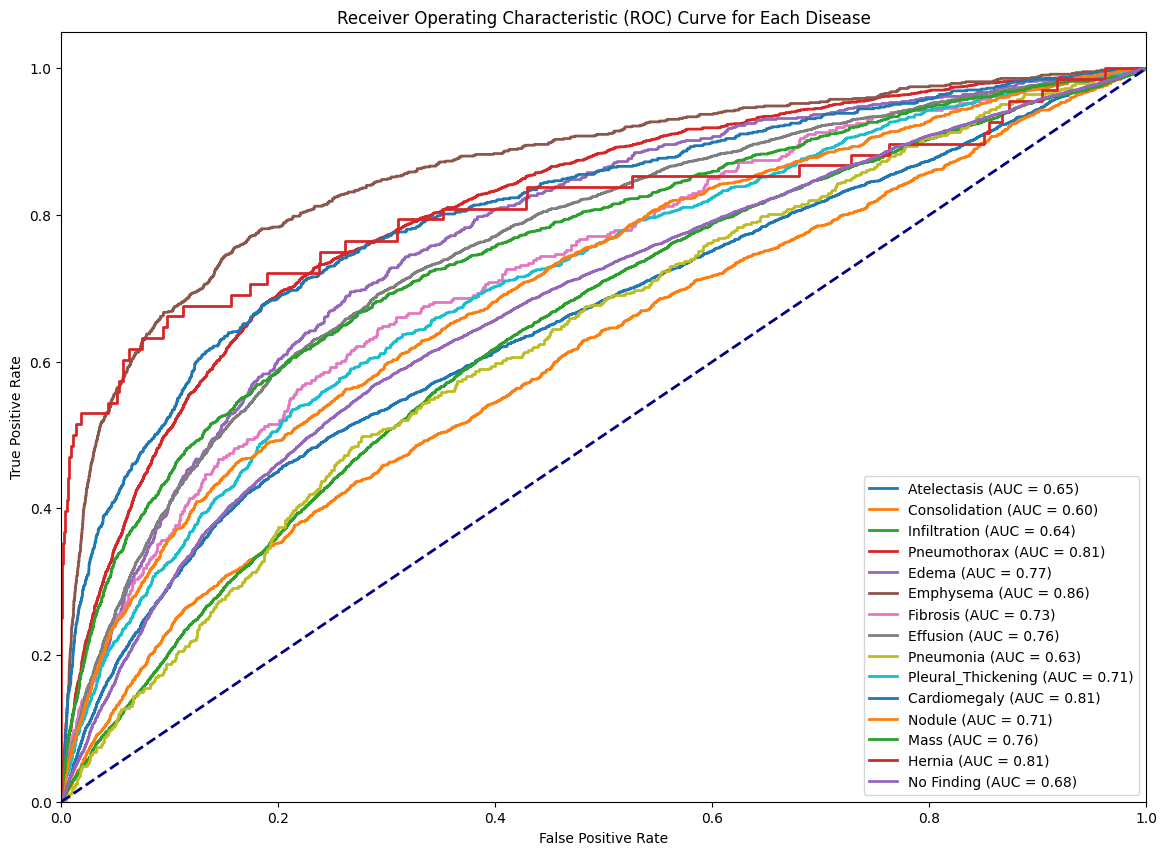

Atelectasis - ROC AUC Score: 0.6509
Consolidation - ROC AUC Score: 0.6050
Infiltration - ROC AUC Score: 0.6407
Pneumothorax - ROC AUC Score: 0.8102
Edema - ROC AUC Score: 0.7737
Emphysema - ROC AUC Score: 0.8639
Fibrosis - ROC AUC Score: 0.7271
Effusion - ROC AUC Score: 0.7577
Pneumonia - ROC AUC Score: 0.6316
Pleural_Thickening - ROC AUC Score: 0.7092
Cardiomegaly - ROC AUC Score: 0.8080
Nodule - ROC AUC Score: 0.7073
Mass - ROC AUC Score: 0.7562
Hernia - ROC AUC Score: 0.8116
No Finding - ROC AUC Score: 0.6755


: 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
for i, disease in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(targets[:, i].cpu(), ensemble_preds[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{disease} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Disease')
plt.legend(loc='lower right')
plt.show()

# Print ROC AUC scores for each class
for i, disease in enumerate(disease_labels):
    roc_auc_label = roc_auc_score(targets[:, i].cpu(), ensemble_preds[:, i])
    print(f'{disease} - ROC AUC Score: {roc_auc_label:.4f}')
